In [3]:
# Import libraries
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
%matplotlib inline

# Utility functions
def sigmoid(x):
    output =1/(1+np.exp(-x))
    return output

def sigmoid_output_to_derivative(output):    
    return output*(1-output)

In [4]:
# Decide the maximum binary dimension (將最大進數的範圍設定成8個字節)
max_binary_dim = 8
largest_number = pow(2, max_binary_dim)
# print(2**8)
# print(pow(2,max_binary_dim))
# print(range(2**3))

# Create binary lookup table

In [5]:
# Create binary lookup table (for convenience)
# np.unpackbits e.g.
print(np.unpackbits(np.array([8], dtype = np.uint8)))
print("====================")
# 以二進制形式生成1到256之間的整數值 (initial is 00000000=0)
# e.g
# binary_gonna_be = np.array([range(largest_number)], dtype=np.uint8).T
# print(binary_gonna_be)

# binary lookup table 完成
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis = 1)
print(binary.shape, binary)
print("====================")
int2binary = {}
for i in range(largest_number):
    int2binary[i] = binary[i]
print("lookup table test")
print(binary[3], int2binary[3])
#print(int2binary)

[0 0 0 0 1 0 0 0]
(256, 8) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
lookup table test
[0 0 0 0 0 0 1 1] [0 0 0 0 0 0 1 1]


# Initial parameter setting

In [6]:
alpha = 0.1 # learning rate
input_dim = 2 # 由於添加了每個數字，因此輸入與要添加的兩個二進制數字的第n個數字相對應的兩個數字。
hidden_dim = 16 # You can vary this and see what happens
output_dim = 1 

# weight initialization
synapse_0 = 2 * np.random.random((input_dim,hidden_dim))-1
synapse_1 = 2 * np.random.random((hidden_dim,output_dim))-1
synapse_h = 2 * np.random.random((hidden_dim,hidden_dim))-1

print(synapse_0.shape, synapse_1.shape, synapse_h.shape)

(2, 16) (16, 1) (16, 16)


In [7]:
# saving for updates and visualization
s0_update = np.zeros(synapse_0.shape) # s0_update = np.zeros_like(synapse_0)
s1_update = np.zeros(synapse_1.shape) 
sh_update = np.zeros(synapse_h.shape) 

overallError_history = list()
accuracy = list()
accuracy_history = list()
accuracy_count = 0

# training

In [8]:
max_iter = 10000
for j in range(max_iter):
    
    # Randomly pick two integers and change it to the binary representation
    a_int = np.random.randint(1,largest_number//2)
    a = int2binary[a_int]
    b_int = np.random.randint(1,largest_number//2)
    b = int2binary[b_int]

    # Calculate the answer and save it as a binary form
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # Declare the variable for saving the prediction by RNN
    pred = np.zeros_like(c)
    
    overallError = 0
    
    output_layer_deltas = list()
    hidden_layer_values = list()
    hidden_layer_values.append(np.zeros(hidden_dim)) # dim: (1, 16)


    for position in reversed(range(max_binary_dim)):
        

        X = np.array([[a[position],b[position]]]) 
        y = np.array([[c[position]]]) 
        
        # hidden layer
        hidden_layer = sigmoid(np.dot(X,synapse_0) + np.dot(hidden_layer_values[-1],synapse_h)) 
        
        # output_layer    
        output_layer = sigmoid(np.dot(hidden_layer,synapse_1)) 
        
        # error 
        output_layer_error = y-output_layer # dim: (1, 1) 
        
        # display
        overallError += np.abs(output_layer_error[0]) # dim: (1, )          
        
        # Save it for the later use in backpropagation step        
        output_layer_deltas.append((output_layer_error) * sigmoid_output_to_derivative(output_layer))        
        
        # save the prediction by my model on this position
        pred[position] = np.round(output_layer[0][0])
        
        # save the hidden layer by appending the values to the list
        hidden_layer_values.append(copy.deepcopy(hidden_layer)) 
    
    if (j%100 == 0):
        overallError_history.append(overallError[0])
    
    # backpropagation
    future_hidden_layer_delta = np.zeros(hidden_dim)
    
    for position in range(max_binary_dim):
        
        X = np.array([[a[position],b[position]]])
        hidden_layer = hidden_layer_values[-position-1]
        prev_hidden_layer = hidden_layer_values[-position-2]
        
        output_layer_delta = output_layer_deltas[-position-1]

        hidden_layer_delta = (np.dot(future_hidden_layer_delta,synapse_h.T) + np.dot(output_layer_delta,synapse_1.T)) \
                            * sigmoid_output_to_derivative(hidden_layer)
        

        s1_update += np.atleast_2d(hidden_layer).T.dot(output_layer_delta)
        sh_update += np.atleast_2d(prev_hidden_layer).T.dot(hidden_layer_delta)
        s0_update += X.T.dot(hidden_layer_delta)
        
        future_hidden_layer_delta = hidden_layer_delta

    # weight update
    synapse_1 += s1_update*alpha
    synapse_0 += s0_update*alpha
    synapse_h += sh_update*alpha
    
    # update value initialization for the new training data 
    s1_update *= 0
    s0_update *= 0    
    sh_update *= 0
    
    # accuracy 
    check = np.equal(pred,c)
    if np.sum(check) == max_binary_dim:
        accuracy_count += 1
    if (j%100 == 0):
        accuracy_history.append(accuracy_count)
        accuracy_count = 0
    
    if (j % 100 == 0):
        print ("Error:" + str(overallError))
        print ("Pred:" + str(pred)) 
        print ("True:" + str(c))  

        final_check = np.equal(pred,c)
        print (np.sum(final_check) == max_binary_dim)

        out = 0

        for index, x in enumerate(reversed(pred)):
            out += x * pow(2, index)
        print (str(a_int) + " + " + str(b_int) + " = " + str(out))
        print ("------------")

Error:[3.97540736]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 0 1 1 1]
False
10 + 61 = 0
------------
Error:[4.0325467]
Pred:[0 1 1 0 1 1 0 1]
True:[1 0 0 1 0 1 0 1]
False
111 + 38 = 109
------------
Error:[3.79424599]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 0 0 0]
False
55 + 1 = 0
------------
Error:[3.87395152]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 1 0 0 1]
False
20 + 5 = 0
------------
Error:[4.01458433]
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 0 1 1 0]
False
12 + 74 = 255
------------
Error:[3.99141219]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 0 1 0]
False
30 + 68 = 0
------------
Error:[3.97121353]
Pred:[0 0 0 0 1 0 0 0]
True:[0 0 1 0 0 0 0 1]
False
28 + 5 = 8
------------
Error:[4.02250446]
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 0 1 1 0 1 1]
False
60 + 31 = 254
------------
Error:[4.04634296]
Pred:[1 1 0 1 0 1 0 1]
True:[0 1 1 1 1 1 1 1]
False
23 + 104 = 213
------------
Error:[3.87790083]
Pred:[1 0 1 1 1 1 1 0]
True:[1 1 0 1 0 1 1 0]
False
124 + 90 = 190
------------
Error:[3.8993887]
Pred:[0 0 0 0

Error:[0.58217015]
Pred:[0 1 1 1 0 0 0 0]
True:[0 1 1 1 0 0 0 0]
True
21 + 91 = 112
------------
Error:[0.50710971]
Pred:[1 0 1 1 1 0 1 0]
True:[1 0 1 1 1 0 1 0]
True
115 + 71 = 186
------------
Error:[0.51719454]
Pred:[0 1 1 1 0 0 0 1]
True:[0 1 1 1 0 0 0 1]
True
18 + 95 = 113
------------
Error:[0.47046102]
Pred:[1 1 1 0 1 1 1 0]
True:[1 1 1 0 1 1 1 0]
True
116 + 122 = 238
------------
Error:[0.51538252]
Pred:[0 1 0 1 0 0 0 1]
True:[0 1 0 1 0 0 0 1]
True
47 + 34 = 81
------------
Error:[0.48485176]
Pred:[1 0 1 1 0 0 0 1]
True:[1 0 1 1 0 0 0 1]
True
73 + 104 = 177
------------
Error:[0.45145853]
Pred:[1 0 1 0 1 0 1 0]
True:[1 0 1 0 1 0 1 0]
True
77 + 93 = 170
------------
Error:[0.38580434]
Pred:[1 0 0 1 1 1 0 1]
True:[1 0 0 1 1 1 0 1]
True
116 + 41 = 157
------------
Error:[0.25024716]
Pred:[1 0 0 1 0 0 0 1]
True:[1 0 0 1 0 0 0 1]
True
80 + 65 = 145
------------
Error:[0.18765659]
Pred:[0 0 1 0 1 0 1 1]
True:[0 0 1 0 1 0 1 1]
True
2 + 41 = 43
------------


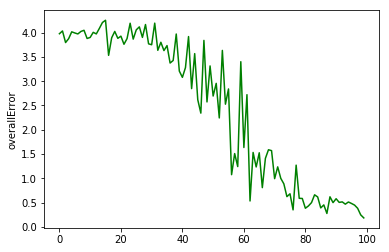

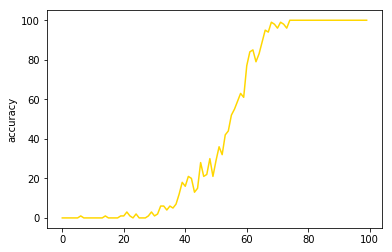

In [14]:
#print(overallError_history)
x_range = range(max_iter//100)
plt.plot(x_range,overallError_history,color = 'green')
plt.ylabel('overallError')
plt.show()

plt.plot(x_range,accuracy_history,color = 'gold')
plt.ylabel('accuracy')
plt.show()

In [10]:
accuracy_history

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 3,
 1,
 2,
 6,
 6,
 4,
 6,
 5,
 7,
 12,
 18,
 16,
 21,
 20,
 13,
 15,
 28,
 21,
 22,
 30,
 21,
 29,
 36,
 32,
 42,
 44,
 52,
 55,
 59,
 63,
 61,
 77,
 84,
 85,
 79,
 83,
 89,
 95,
 94,
 99,
 98,
 96,
 99,
 98,
 96,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100]